## Midterm Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

%matplotlib inline


## Data Preparation

In [2]:
df = pd.read_csv('insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [5]:
numerical_columns = ["age","bmi","children"]
categorical_columns = ["sex","smoker","region"]
columns = numerical_columns + categorical_columns

In [6]:
df.duplicated().value_counts()

False    1337
True        1
dtype: int64

In [7]:
#"In general, try to avoid having duplicates across train-validation-test splits"
df = df.drop_duplicates()

In [8]:
#Setting up the validation framework
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

In [10]:
y_train = df_train.charges.values
y_val = df_val.charges.values
y_full_train = df_full_train.charges.values
y_test = df_test.charges.values

del df_train['charges']
del df_val['charges']
del df_test['charges']

## EDA

In [11]:
df_full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1069 non-null   int64  
 1   sex       1069 non-null   object 
 2   bmi       1069 non-null   float64
 3   children  1069 non-null   int64  
 4   smoker    1069 non-null   object 
 5   region    1069 non-null   object 
 6   charges   1069 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 58.6+ KB


In [12]:
for col in df_full_train.columns:
    print(col)
    print(f"Number of unique values : {df[col].nunique()}")
    print()

age
Number of unique values : 47

sex
Number of unique values : 2

bmi
Number of unique values : 548

children
Number of unique values : 6

smoker
Number of unique values : 2

region
Number of unique values : 4

charges
Number of unique values : 1337



<AxesSubplot:xlabel='charges', ylabel='Count'>

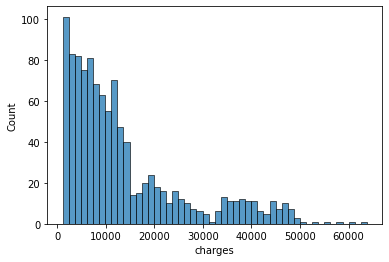

In [13]:
#Distribution of charges
sns.histplot(df_full_train.charges, bins=50)

<AxesSubplot:xlabel='charges', ylabel='Count'>

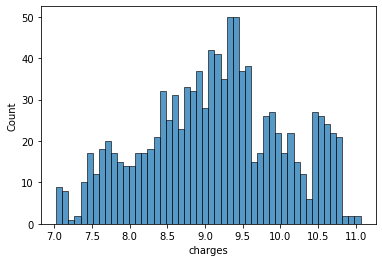

In [14]:
#Solving the Long Tail
charge_logs = np.log1p(df_full_train.charges)
sns.histplot(charge_logs, bins=50)

In [15]:
#As a result, charges should be logaritmic
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
y_full_train = np.log1p(y_full_train)
y_test = np.log1p(y_test)

In [16]:
df.describe().round()

,age,bmi,children,charges
count,1337.0,1337.0,1337.0,1337.0
mean,39.0,31.0,1.0,13279.0
std,14.0,6.0,1.0,12110.0
min,18.0,16.0,0.0,1122.0
25%,27.0,26.0,0.0,4746.0
50%,39.0,30.0,1.0,9386.0
75%,51.0,35.0,2.0,16658.0
max,64.0,53.0,5.0,63770.0


C:\Users\DIEGOC~1\AppData\Local\Temp/ipykernel_16116/101839538.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(bins=100, ax=ax, layout=(3, 1), column=numerical_columns)


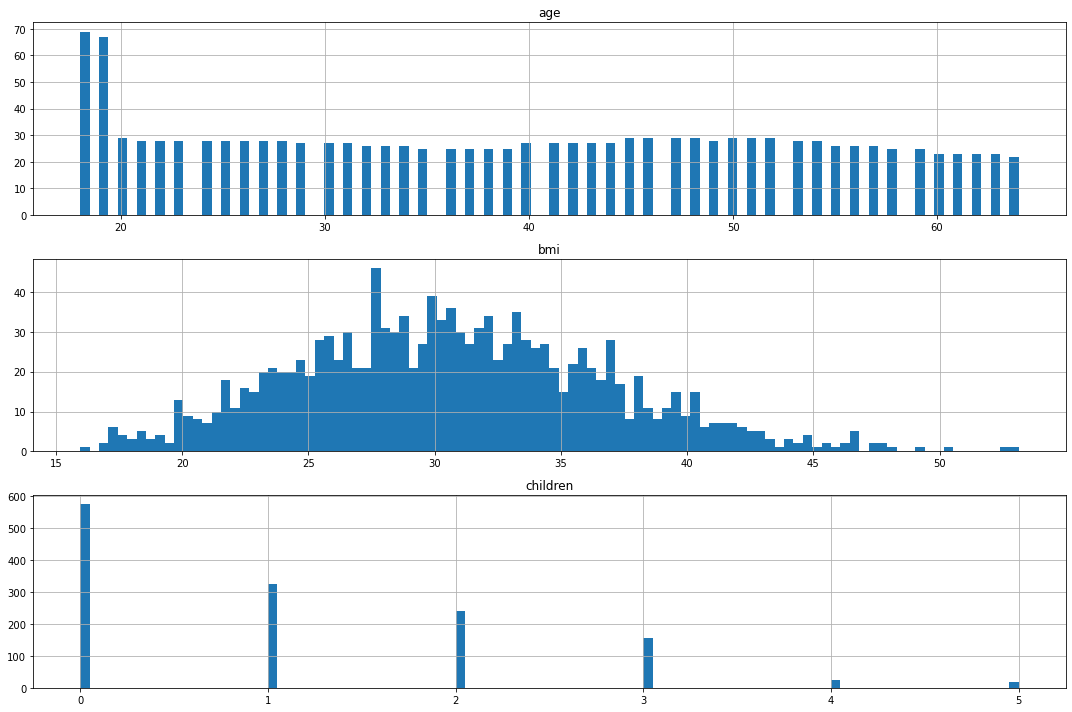

In [17]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
df.hist(bins=100, ax=ax, layout=(3, 1), column=numerical_columns)
plt.tight_layout()
plt.show()

In [18]:
#Correlation
df_numeric = df_full_train.copy()
data_numeric = df_numeric.drop(["charges"]+categorical_columns, axis=1)
data_numeric.describe()

,age,bmi,children
count,1069.000000,1069.000000,1069.000000
mean,39.166511,30.622736,1.101964
std,13.994326,6.009016,1.197644
min,18.000000,15.960000,0.000000
25%,27.000000,26.315000,0.000000
50%,39.000000,30.210000,1.000000
75%,51.000000,34.580000,2.000000
max,64.000000,53.130000,5.000000


In [19]:
data_numeric.corr()

,age,bmi,children
age,1.000000,0.117425,0.02636
bmi,0.117425,1.000000,-0.00120
children,0.026360,-0.001200,1.00000


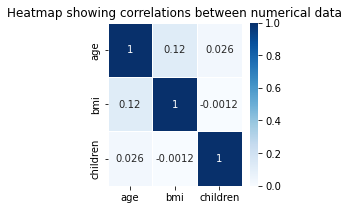

In [20]:
plt.figure(figsize=(3,3))  
sns.heatmap(data_numeric.corr(),annot=True,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between numerical data')
plt.show()

In [21]:
#Correlation of numerical features with the target
df_full_train[numerical_columns].corrwith(df_full_train.charges).to_frame('correlation').sort_values('correlation',ascending = False)

,correlation
age,0.283212
bmi,0.207291
children,0.074667


In [22]:
#To use mutual information we need to transform the numerical data into categorical 
qcharges = pd.qcut(y_full_train, q=10)

In [23]:
def calculate_mi(series):
    return mutual_info_score(series, qcharges)

df_mi = df_full_train[categorical_columns].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

In [24]:
df_mi

,MI
smoker,0.367450
region,0.016676
sex,0.008435


In [25]:
#One Hot Encoding
train_dict = df_train[categorical_columns +numerical_columns].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

## Linear Regression

In [26]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred_lr = lr.predict(X_train)

In [27]:
val_dict = df_val[categorical_columns +numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_val_pred_lr = lr.predict(X_val)

In [28]:
print(f"MSE train data: {round((mean_squared_error(y_train,y_train_pred_lr)),3)}")
print(f"R^2 train data: {round((r2_score(y_train,y_train_pred_lr)),3)}")
print(f"MSE val data: {round((mean_squared_error(y_val,y_val_pred_lr)),3)}")
print(f"R^2 val data: {round((r2_score(y_val,y_val_pred_lr)),3)}")

MSE train data: 0.192
R^2 train data: 0.765
MSE val data: 0.219
R^2 val data: 0.76


## Parameter Turning LR 

In [29]:
#Parameter Tuning Linear Regression
#fit_interceptbool, default=True
#normalizebool, default=False
#positivebool, default=False
lr = LinearRegression(fit_intercept=False)
lr.fit(X_train, y_train)
y_train_pred_lr = lr.predict(X_train)
X_val = dv.transform(val_dict)
y_val_pred_lr = lr.predict(X_val)
print(f"MSE train data: {round((mean_squared_error(y_train,y_train_pred_lr)),3)}")
print(f"R^2 train data: {round((r2_score(y_train,y_train_pred_lr)),3)}")
print(f"MSE val data: {round((mean_squared_error(y_val,y_val_pred_lr)),3)}")
print(f"R^2 val data: {round((r2_score(y_val,y_val_pred_lr)),3)}")

MSE train data: 0.192
R^2 train data: 0.765
MSE val data: 0.219
R^2 val data: 0.76


In [30]:
lr = LinearRegression(normalize=True)
lr.fit(X_train, y_train)
y_train_pred_lr = lr.predict(X_train)
X_val = dv.transform(val_dict)
y_val_pred_lr = lr.predict(X_val)
print(f"MSE val data: {round((mean_squared_error(y_val,y_val_pred_lr)),3)}")
print(f"R^2 val data: {round((r2_score(y_val,y_val_pred_lr)),3)}")

MSE val data: 0.219
R^2 val data: 0.76


In [31]:
lr = LinearRegression(positive=True)
lr.fit(X_train, y_train)
y_train_pred_lr = lr.predict(X_train)
X_val = dv.transform(val_dict)
y_val_pred_lr = lr.predict(X_val)
print(f"MSE val data: {round((mean_squared_error(y_val,y_val_pred_lr)),3)}")
print(f"R^2 val data: {round((r2_score(y_val,y_val_pred_lr)),3)}")

MSE val data: 0.219
R^2 val data: 0.76


Result: Default parameters

## Ridge Regression

In [32]:
#RidgeRegression (regularized). Find the best regularization parameter for Ridge
rr = Ridge()
rr.fit(X_train, y_train)
y_train_pred_rr = rr.predict(X_train)

val_dict = df_val[categorical_columns +numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_val_pred_rr = rr.predict(X_val)

print(f"MSE train data: {round((mean_squared_error(y_train,y_train_pred_rr)),3)}")
print(f"R^2 train data: {round((r2_score(y_train,y_train_pred_rr)),3)}")
print(f"MSE val data: {round((mean_squared_error(y_val,y_val_pred_rr)),3)}")
print(f"R^2 val data: {round((r2_score(y_val,y_val_pred_rr)),3)}")

MSE train data: 0.192
R^2 train data: 0.765
MSE val data: 0.22
R^2 val data: 0.76


## Parameter Tuning RR

In [33]:
#Parameter Tuning Linear Regression
#alpha, default=1.0
#fit_intercept, default=True
#normalize, default=False
#solver{‘auto’, ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’, ‘lbfgs’}, default=’auto’
#positive, default=False , Only ‘lbfgs’ solver is supported in this case.
#random_state , RandomState instance, default=None Used when solver == ‘sag’ or ‘saga’ to shuffle the data. 

for a in [0, 0.01, 0.1, 1, 10, 100,1000]:
    rr = Ridge(alpha=a)
    rr.fit(X_train, y_train)
    y_train_pred_rr = rr.predict(X_train)
    X_val = dv.transform(val_dict)
    y_val_pred_rr = rr.predict(X_val)
    print(f"alpha:{a}")
    print(f"MSE val data: {round((mean_squared_error(y_val,y_val_pred_rr)),3)}")
    print(f"R^2 val data: {round((r2_score(y_val,y_val_pred_rr)),3)}")


alpha:0
MSE val data: 0.221
R^2 val data: 0.758
alpha:0.01
MSE val data: 0.219
R^2 val data: 0.76
alpha:0.1
MSE val data: 0.219
R^2 val data: 0.76
alpha:1
MSE val data: 0.22
R^2 val data: 0.76
alpha:10
MSE val data: 0.221
R^2 val data: 0.758
alpha:100
MSE val data: 0.259
R^2 val data: 0.717
alpha:1000
MSE val data: 0.502
R^2 val data: 0.451


In [34]:
solver = ['sparse_cg', 'cholesky', 'svd', 'lsqr', 'sag','saga']
for s in solver:
    
    rr = Ridge(alpha = 0.1,solver = s)
    rr.fit(X_train, y_train)
    y_train_pred_rr = rr.predict(X_train)
    X_val = dv.transform(val_dict)
    y_val_pred_rr = rr.predict(X_val)
    print(f"solver:{s}")
    print(f"MSE val data: {round((mean_squared_error(y_val,y_val_pred_rr)),3)}")
    print(f"R^2 val data: {round((r2_score(y_val,y_val_pred_rr)),3)}")

    

solver:sparse_cg
MSE val data: 0.219
R^2 val data: 0.76
solver:cholesky
MSE val data: 0.219
R^2 val data: 0.76
solver:svd
MSE val data: 0.219
R^2 val data: 0.76
solver:lsqr
MSE val data: 0.219
R^2 val data: 0.76
solver:sag
MSE val data: 0.22
R^2 val data: 0.76
solver:saga
MSE val data: 0.22
R^2 val data: 0.76


In [35]:
rr = Ridge(alpha = 0.1, fit_intercept = False)
rr.fit(X_train, y_train)
y_train_pred_rr = rr.predict(X_train)
X_val = dv.transform(val_dict)
y_val_pred_rr = rr.predict(X_val)
print(f"MSE val data: {round((mean_squared_error(y_val,y_val_pred_rr)),3)}")
print(f"R^2 val data: {round((r2_score(y_val,y_val_pred_rr)),3)}")

MSE val data: 0.219
R^2 val data: 0.76


Result: Default parameters, except alpha = 0.1

## Decision Trees

In [36]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_train_pred_dt = dt.predict(X_train)
X_val = dv.transform(val_dict)
y_val_pred_dt = dt.predict(X_val)
print(f"MSE train data: {round((mean_squared_error(y_train,y_train_pred_dt)),3)}")
print(f"R^2 train data: {round((r2_score(y_train,y_train_pred_dt)),3)}")
print(f"MSE val data: {round((mean_squared_error(y_val,y_val_pred_dt)),3)}")
print(f"R^2 val data: {round((r2_score(y_val,y_val_pred_dt)),3)}")

MSE train data: 0.0
R^2 train data: 1.0
MSE val data: 0.271
R^2 val data: 0.704


## Parameter Tuning DT

In [37]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(X_train, y_train)
    y_train_pred_dt = rr.predict(X_train)
    X_val = dv.transform(val_dict)
    y_val_pred_dt = dt.predict(X_val)
    print(f"depth : {depth}")
    print(f"MSE val data: {round((mean_squared_error(y_val,y_val_pred_dt)),3)}")
    print(f"R^2 val data: {round((r2_score(y_val,y_val_pred_dt)),3)}")

depth : 1
MSE val data: 0.521
R^2 val data: 0.43
depth : 2
MSE val data: 0.268
R^2 val data: 0.707
depth : 3
MSE val data: 0.214
R^2 val data: 0.765
depth : 4
MSE val data: 0.2
R^2 val data: 0.781
depth : 5
MSE val data: 0.181
R^2 val data: 0.802
depth : 6
MSE val data: 0.224
R^2 val data: 0.756
depth : 10
MSE val data: 0.262
R^2 val data: 0.713
depth : 15
MSE val data: 0.278
R^2 val data: 0.697
depth : 20
MSE val data: 0.276
R^2 val data: 0.698
depth : None
MSE val data: 0.264
R^2 val data: 0.712


In [38]:
for m in [1, 5, 10, 15, 20, 50, 100, 200]:
    dt = DecisionTreeRegressor(max_depth=5, min_samples_leaf=m)
    dt.fit(X_train, y_train)
    y_train_pred_dt = rr.predict(X_train)
    X_val = dv.transform(val_dict)
    y_val_pred_dt = dt.predict(X_val)
    print(f"min_samples_leaf : {m}")
    print(f"MSE val data: {round((mean_squared_error(y_val,y_val_pred_dt)),3)}")
    print(f"R^2 val data: {round((r2_score(y_val,y_val_pred_dt)),3)}")

min_samples_leaf : 1
MSE val data: 0.181
R^2 val data: 0.802
min_samples_leaf : 5
MSE val data: 0.182
R^2 val data: 0.801
min_samples_leaf : 10
MSE val data: 0.18
R^2 val data: 0.803
min_samples_leaf : 15
MSE val data: 0.18
R^2 val data: 0.803
min_samples_leaf : 20
MSE val data: 0.198
R^2 val data: 0.783
min_samples_leaf : 50
MSE val data: 0.198
R^2 val data: 0.784
min_samples_leaf : 100
MSE val data: 0.233
R^2 val data: 0.745
min_samples_leaf : 200
MSE val data: 0.706
R^2 val data: 0.228


Result : depth = 5 and min_sample_leaf = 10

## Random Forest

In [39]:
rf = RandomForestRegressor(random_state=1)
rf.fit(X_train, y_train)
y_train_pred_rf = rf.predict(X_train)
X_val = dv.transform(val_dict)
y_val_pred_rf = rf.predict(X_val)
print(f"MSE train data: {round((mean_squared_error(y_train,y_train_pred_rf)),3)}")
print(f"R^2 train data: {round((r2_score(y_train,y_train_pred_rf)),3)}")
print(f"MSE val data: {round((mean_squared_error(y_val,y_val_pred_rf)),3)}")
print(f"R^2 val data: {round((r2_score(y_val,y_val_pred_rf)),3)}")

MSE train data: 0.02
R^2 train data: 0.975
MSE val data: 0.197
R^2 val data: 0.785


## Parameter Turning RF

In [40]:
r2_train = []
r2_val = []

for i in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=i,random_state=1)
    rf.fit(X_train, y_train)
    y_train_pred_rf = rf.predict(X_train)
    X_val = dv.transform(val_dict)
    y_val_pred_rf = rf.predict(X_val)
    print(f"number of estimators: {i}")
    print(f"MSE val data: {round((mean_squared_error(y_val,y_val_pred_rf)),3)}")
    print(f"R^2 val data: {round((r2_score(y_val,y_val_pred_rf)),3)}")
    r2_val.append(round((r2_score(y_val,y_val_pred_rf)),3))

number of estimators: 10
MSE val data: 0.197
R^2 val data: 0.784
number of estimators: 20
MSE val data: 0.205
R^2 val data: 0.776
number of estimators: 30
MSE val data: 0.2
R^2 val data: 0.782
number of estimators: 40
MSE val data: 0.198
R^2 val data: 0.784
number of estimators: 50
MSE val data: 0.198
R^2 val data: 0.784
number of estimators: 60
MSE val data: 0.195
R^2 val data: 0.786
number of estimators: 70
MSE val data: 0.195
R^2 val data: 0.787
number of estimators: 80
MSE val data: 0.195
R^2 val data: 0.787
number of estimators: 90
MSE val data: 0.196
R^2 val data: 0.785
number of estimators: 100
MSE val data: 0.197
R^2 val data: 0.785
number of estimators: 110
MSE val data: 0.193
R^2 val data: 0.788
number of estimators: 120
MSE val data: 0.192
R^2 val data: 0.79
number of estimators: 130
MSE val data: 0.193
R^2 val data: 0.789
number of estimators: 140
MSE val data: 0.192
R^2 val data: 0.79
number of estimators: 150
MSE val data: 0.192
R^2 val data: 0.79
number of estimators: 16

Text(0, 0.5, 'R^2 score')

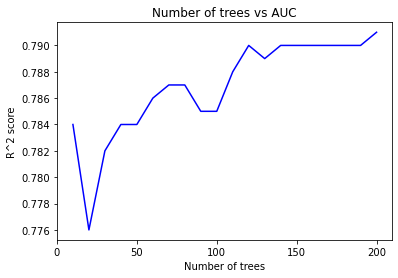

In [41]:
plt.figure(figsize=(6, 4))

plt.plot(range(10, 201, 10), r2_val,label='val', color='blue')
plt.xticks(range(0, 201, 50))

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('R^2 score')


In [42]:
all_r2 = {}

for depth in [5, 10, 20]:
    print('depth: %s' % depth)
    r2s = []

    for i in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=i, max_depth=depth, random_state=1)
        rf.fit(X_train, y_train)
        y_val_pred_rf = rf.predict(X_val)
        r2 = round((r2_score(y_val,y_val_pred_rf)),3)
        print('%s -> %.3f' % (i, r2))
        r2s.append(r2)
    
    all_r2[depth] = r2s
    print()


depth: 5
10 -> 0.814
20 -> 0.812
30 -> 0.810
40 -> 0.808
50 -> 0.807
60 -> 0.807
70 -> 0.808
80 -> 0.808
90 -> 0.807
100 -> 0.807
110 -> 0.808
120 -> 0.808
130 -> 0.808
140 -> 0.808
150 -> 0.808
160 -> 0.808
170 -> 0.808
180 -> 0.808
190 -> 0.808
200 -> 0.808

depth: 10
10 -> 0.789
20 -> 0.777
30 -> 0.786
40 -> 0.788
50 -> 0.786
60 -> 0.788
70 -> 0.788
80 -> 0.788
90 -> 0.787
100 -> 0.786
110 -> 0.790
120 -> 0.791
130 -> 0.790
140 -> 0.790
150 -> 0.791
160 -> 0.791
170 -> 0.791
180 -> 0.791
190 -> 0.792
200 -> 0.792

depth: 20
10 -> 0.784
20 -> 0.776
30 -> 0.782
40 -> 0.784
50 -> 0.784
60 -> 0.786
70 -> 0.787
80 -> 0.787
90 -> 0.785
100 -> 0.785
110 -> 0.788
120 -> 0.790
130 -> 0.789
140 -> 0.790
150 -> 0.790
160 -> 0.790
170 -> 0.790
180 -> 0.790
190 -> 0.790
200 -> 0.791



depth = 5, estimators = 10

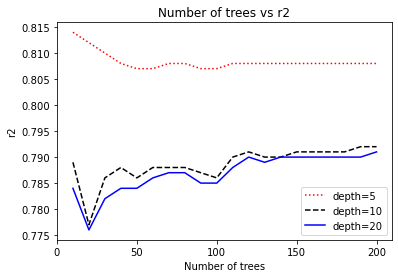

In [43]:
plt.figure(figsize=(6, 4))

num_trees = list(range(10, 201, 10))

plt.plot(num_trees, all_r2[5], label='depth=5', color='red', linestyle='dotted')
plt.plot(num_trees, all_r2[10], label='depth=10', color='black', linestyle='dashed')
plt.plot(num_trees, all_r2[20], label='depth=20', color='blue', linestyle='solid')
    
plt.xticks(range(0, 201, 50))
plt.legend()

plt.title('Number of trees vs r2')
plt.xlabel('Number of trees')
plt.ylabel('r2')

# plt.savefig('ch06-figures/06_random_forest_n_estimators_depth.svg')

plt.show()

In [44]:
#Tuning the min_samples_leaf parameter
all_r2 = {}

for m in [1,3, 5, 10]:
    print('min_samples_leaf: %s' % m)
    r2s = []

    for i in range(10, 201, 20):
        rf = RandomForestRegressor(n_estimators=i, max_depth=5, min_samples_leaf=m, random_state=1)
        rf.fit(X_train, y_train)
        y_val_pred_rf = rf.predict(X_val)
        r2 = round((r2_score(y_val,y_val_pred_rf)),3)
        print('%s -> %.3f' % (i, r2))
        r2s.append(r2)
    
    all_r2[m] = r2s
    print()

min_samples_leaf: 1
10 -> 0.814
30 -> 0.810
50 -> 0.807
70 -> 0.808
90 -> 0.807
110 -> 0.808
130 -> 0.808
150 -> 0.808
170 -> 0.808
190 -> 0.808

min_samples_leaf: 3
10 -> 0.810
30 -> 0.809
50 -> 0.808
70 -> 0.809
90 -> 0.808
110 -> 0.808
130 -> 0.809
150 -> 0.808
170 -> 0.808
190 -> 0.808

min_samples_leaf: 5
10 -> 0.809
30 -> 0.809
50 -> 0.806
70 -> 0.808
90 -> 0.808
110 -> 0.808
130 -> 0.808
150 -> 0.808
170 -> 0.808
190 -> 0.808

min_samples_leaf: 10
10 -> 0.809
30 -> 0.807
50 -> 0.807
70 -> 0.808
90 -> 0.808
110 -> 0.809
130 -> 0.809
150 -> 0.808
170 -> 0.808
190 -> 0.808



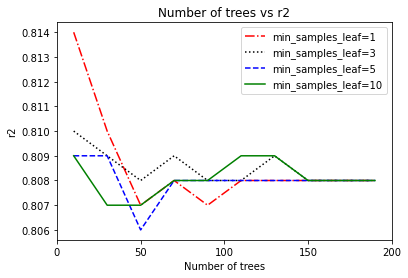

In [45]:
plt.figure(figsize=(6, 4))

num_trees = list(range(10, 201, 20))

plt.plot(num_trees, all_r2[1], label='min_samples_leaf=1', color='red', linestyle='dashdot')
plt.plot(num_trees, all_r2[3], label='min_samples_leaf=3', color='black', linestyle='dotted')
plt.plot(num_trees, all_r2[5], label='min_samples_leaf=5', color='blue', linestyle='dashed')
plt.plot(num_trees, all_r2[10], label='min_samples_leaf=10', color='green', linestyle='solid')
    
plt.xticks(range(0, 201, 50))
plt.legend()

plt.title('Number of trees vs r2')
plt.xlabel('Number of trees')
plt.ylabel('r2')

# plt.savefig('ch06-figures/06_random_forest_n_estimators_sample_leaf.svg')

plt.show()

In [46]:
#min_samples_leaf = 1 = default

Result: n_estimators=10, max_depth=5, min_samples_leaf=1

## ExtraTrees Regressor

In [47]:
et = ExtraTreesRegressor()
et.fit(X_train, y_train)
y_train_pred_et = et.predict(X_train)
X_val = dv.transform(val_dict)
y_val_pred_et = et.predict(X_val)
print(f"MSE train data: {round((mean_squared_error(y_train,y_train_pred_et)),3)}")
print(f"R^2 train data: {round((r2_score(y_train,y_train_pred_et)),3)}")
print(f"MSE val data: {round((mean_squared_error(y_val,y_val_pred_et)),3)}")
print(f"R^2 val data: {round((r2_score(y_val,y_val_pred_et)),3)}")

MSE train data: 0.0
R^2 train data: 1.0
MSE val data: 0.226
R^2 val data: 0.753


## Parameter Tuning ET

In [48]:
r2_train = []
r2_val = []

for i in range(10, 201, 10):
    et = ExtraTreesRegressor(n_estimators=i,random_state=1)
    et.fit(X_train, y_train)
    y_train_pred_et = et.predict(X_train)
    X_val = dv.transform(val_dict)
    y_val_pred_et = et.predict(X_val)
    print(f"number of estimators: {i}")
    print(f"MSE val data: {round((mean_squared_error(y_val,y_val_pred_et)),3)}")
    print(f"R^2 val data: {round((r2_score(y_val,y_val_pred_et)),3)}")
    r2_val.append(round((r2_score(y_val,y_val_pred_et)),3))

number of estimators: 10
MSE val data: 0.23
R^2 val data: 0.749
number of estimators: 20
MSE val data: 0.228
R^2 val data: 0.751
number of estimators: 30
MSE val data: 0.229
R^2 val data: 0.75
number of estimators: 40
MSE val data: 0.227
R^2 val data: 0.751
number of estimators: 50
MSE val data: 0.227
R^2 val data: 0.752
number of estimators: 60
MSE val data: 0.227
R^2 val data: 0.752
number of estimators: 70
MSE val data: 0.226
R^2 val data: 0.753
number of estimators: 80
MSE val data: 0.225
R^2 val data: 0.754
number of estimators: 90
MSE val data: 0.224
R^2 val data: 0.755
number of estimators: 100
MSE val data: 0.224
R^2 val data: 0.755
number of estimators: 110
MSE val data: 0.224
R^2 val data: 0.755
number of estimators: 120
MSE val data: 0.224
R^2 val data: 0.755
number of estimators: 130
MSE val data: 0.224
R^2 val data: 0.755
number of estimators: 140
MSE val data: 0.223
R^2 val data: 0.756
number of estimators: 150
MSE val data: 0.224
R^2 val data: 0.755
number of estimators:

Text(0, 0.5, 'R^2 score')

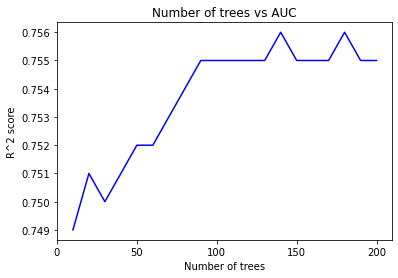

In [49]:
plt.figure(figsize=(6, 4))

plt.plot(range(10, 201, 10), r2_val,label='val', color='blue')
plt.xticks(range(0, 201, 50))

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('R^2 score')


In [50]:
all_r2 = {}

for depth in [5, 10, 20]:
    print('depth: %s' % depth)
    r2s = []

    for i in range(10, 201, 10):
        et = ExtraTreesRegressor(n_estimators=i, max_depth=depth,random_state=1)
        et.fit(X_train, y_train)
        y_val_pred_et = et.predict(X_val)
        r2 = round((r2_score(y_val,y_val_pred_et)),3)
        print('%s -> %.3f' % (i, r2))
        r2s.append(r2)
    
    all_r2[depth] = r2s
    print()


depth: 5
10 -> 0.813
20 -> 0.813
30 -> 0.814
40 -> 0.815
50 -> 0.815
60 -> 0.816
70 -> 0.816
80 -> 0.816
90 -> 0.817
100 -> 0.816
110 -> 0.816
120 -> 0.816
130 -> 0.816
140 -> 0.816
150 -> 0.816
160 -> 0.816
170 -> 0.816
180 -> 0.816
190 -> 0.816
200 -> 0.816

depth: 10
10 -> 0.779
20 -> 0.795
30 -> 0.798
40 -> 0.799
50 -> 0.799
60 -> 0.800
70 -> 0.799
80 -> 0.800
90 -> 0.800
100 -> 0.800
110 -> 0.799
120 -> 0.799
130 -> 0.799
140 -> 0.799
150 -> 0.798
160 -> 0.799
170 -> 0.798
180 -> 0.798
190 -> 0.797
200 -> 0.798

depth: 20
10 -> 0.748
20 -> 0.752
30 -> 0.751
40 -> 0.752
50 -> 0.752
60 -> 0.752
70 -> 0.752
80 -> 0.753
90 -> 0.754
100 -> 0.755
110 -> 0.755
120 -> 0.755
130 -> 0.754
140 -> 0.755
150 -> 0.755
160 -> 0.755
170 -> 0.754
180 -> 0.755
190 -> 0.754
200 -> 0.754



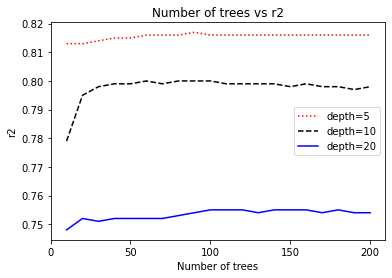

In [51]:
plt.figure(figsize=(6, 4))

num_trees = list(range(10, 201, 10))

plt.plot(num_trees, all_r2[5], label='depth=5', color='red', linestyle='dotted')
plt.plot(num_trees, all_r2[10], label='depth=10', color='black', linestyle='dashed')
plt.plot(num_trees, all_r2[20], label='depth=20', color='blue', linestyle='solid')
    
plt.xticks(range(0, 201, 50))
plt.legend()

plt.title('Number of trees vs r2')
plt.xlabel('Number of trees')
plt.ylabel('r2')


plt.show()

In [52]:
#Tuning the min_samples_leaf parameter
all_r2 = {}

for m in [1,3, 5, 10]:
    print('min_samples_leaf: %s' % m)
    r2s = []

    for i in range(10, 201, 20):
        et = ExtraTreesRegressor(n_estimators=i, max_depth=5, min_samples_leaf=m, random_state=1)
        et.fit(X_train, y_train)
        y_val_pred_et = et.predict(X_val)
        r2 = round((r2_score(y_val,y_val_pred_et)),3)
        print('%s -> %.3f' % (i, r2))
        r2s.append(r2)
    
    all_r2[m] = r2s
    print()

min_samples_leaf: 1
10 -> 0.813
30 -> 0.814
50 -> 0.815
70 -> 0.816
90 -> 0.817
110 -> 0.816
130 -> 0.816
150 -> 0.816
170 -> 0.816
190 -> 0.816

min_samples_leaf: 3
10 -> 0.807
30 -> 0.810
50 -> 0.814
70 -> 0.815
90 -> 0.815
110 -> 0.815
130 -> 0.815
150 -> 0.815
170 -> 0.815
190 -> 0.815

min_samples_leaf: 5
10 -> 0.809
30 -> 0.814
50 -> 0.816
70 -> 0.816
90 -> 0.816
110 -> 0.816
130 -> 0.815
150 -> 0.816
170 -> 0.816
190 -> 0.816

min_samples_leaf: 10
10 -> 0.812
30 -> 0.815
50 -> 0.813
70 -> 0.812
90 -> 0.813
110 -> 0.814
130 -> 0.814
150 -> 0.814
170 -> 0.814
190 -> 0.814



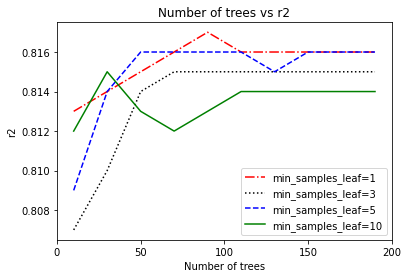

In [53]:
plt.figure(figsize=(6, 4))

num_trees = list(range(10, 201, 20))

plt.plot(num_trees, all_r2[1], label='min_samples_leaf=1', color='red', linestyle='dashdot')
plt.plot(num_trees, all_r2[3], label='min_samples_leaf=3', color='black', linestyle='dotted')
plt.plot(num_trees, all_r2[5], label='min_samples_leaf=5', color='blue', linestyle='dashed')
plt.plot(num_trees, all_r2[10], label='min_samples_leaf=10', color='green', linestyle='solid')
    
plt.xticks(range(0, 201, 50))
plt.legend()

plt.title('Number of trees vs r2')
plt.xlabel('Number of trees')
plt.ylabel('r2')

# plt.savefig('ch06-figures/06_random_forest_n_estimators_sample_leaf.svg')

plt.show()

Result: n_estimators=90, max_depth=5, min_samples_leaf=1

## Final Test

In [54]:
del df_full_train['charges']

In [55]:
full_train_dict = df_full_train[categorical_columns +numerical_columns].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(full_train_dict)
X_full_train = dv.transform(full_train_dict)

test_dict = df_test[categorical_columns +numerical_columns].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [56]:
lr = LinearRegression()
lr.fit(X_full_train, y_full_train)
y_full_train_pred_lr = lr.predict(X_full_train)
y_test_pred_lr = lr.predict(X_test)

print(f"MSE full_train data: {round((mean_squared_error(y_full_train,y_full_train_pred_lr)),3)}")
print(f"R^2 full_train data: {round((r2_score(y_full_train,y_full_train_pred_lr)),3)}")
print(f"MSE test data: {round((mean_squared_error(y_test,y_test_pred_lr)),3)}")
print(f"R^2 test data: {round((r2_score(y_test,y_test_pred_lr)),3)}")

MSE full_train data: 0.198
R^2 full_train data: 0.764
MSE test data: 0.189
R^2 test data: 0.772


In [57]:
rr = Ridge(alpha = 0.1)
rr.fit(X_full_train, y_full_train)
y_full_train_pred_rr = rr.predict(X_full_train)
X_test = dv.transform(test_dict)
y_test_pred_rr = rr.predict(X_test)
print(f"MSE full_train data: {round((mean_squared_error(y_full_train,y_full_train_pred_rr)),3)}")
print(f"R^2 full_train data: {round((r2_score(y_full_train,y_full_train_pred_rr)),3)}")
print(f"MSE test data: {round((mean_squared_error(y_test,y_test_pred_rr)),3)}")
print(f"R^2 test data: {round((r2_score(y_test,y_test_pred_rr)),3)}")

MSE full_train data: 0.198
R^2 full_train data: 0.764
MSE test data: 0.189
R^2 test data: 0.772


In [58]:
dt = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10)
dt.fit(X_full_train, y_full_train)
y_full_train_pred_dt = dt.predict(X_full_train)
y_test_pred_dt = dt.predict(X_test)
print(f"MSE full_train data: {round((mean_squared_error(y_full_train,y_full_train_pred_dt)),3)}")
print(f"R^2 full_train data: {round((r2_score(y_full_train,y_full_train_pred_dt)),3)}")
print(f"MSE test data: {round((mean_squared_error(y_test,y_test_pred_dt)),3)}")
print(f"R^2 test data: {round((r2_score(y_test,y_test_pred_dt)),3)}")

MSE full_train data: 0.13
R^2 full_train data: 0.846
MSE test data: 0.147
R^2 test data: 0.822


In [59]:
rf = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_leaf=1, random_state=1)
rf.fit(X_full_train, y_full_train)
y_full_train_pred_rf = rf.predict(X_full_train)
y_test_pred_rf = rf.predict(X_test)
print(f"MSE full_train data: {round((mean_squared_error(y_full_train,y_full_train_pred_rf)),3)}")
print(f"R^2 full_train data: {round((r2_score(y_full_train,y_full_train_pred_rf)),3)}")
print(f"MSE test data: {round((mean_squared_error(y_test,y_test_pred_rf)),3)}")
print(f"R^2 test data: {round((r2_score(y_test,y_test_pred_rf)),3)}")


MSE full_train data: 0.12
R^2 full_train data: 0.858
MSE test data: 0.134
R^2 test data: 0.838


In [60]:
et = ExtraTreesRegressor(n_estimators=90, max_depth=5, min_samples_leaf=1, random_state=1)
et.fit(X_full_train, y_full_train)
y_full_train_pred_et = et.predict(X_full_train)
y_test_pred_et = et.predict(X_test)
print(f"MSE full_train data: {round((mean_squared_error(y_full_train,y_full_train_pred_et)),3)}")
print(f"R^2 full_train data: {round((r2_score(y_full_train,y_full_train_pred_et)),3)}")
print(f"MSE test data: {round((mean_squared_error(y_test,y_test_pred_et)),3)}")
print(f"R^2 test data: {round((r2_score(y_test,y_test_pred_et)),3)}")

MSE full_train data: 0.132
R^2 full_train data: 0.843
MSE test data: 0.13
R^2 test data: 0.843


Result: Extra Trees Regressor is the best model